In [1]:
from datetime import datetime, timezone
import pytz

utc_dt = datetime.now(timezone.utc) # UTC time
dt = utc_dt.astimezone()
tz = pytz.timezone('Europe/Berlin')
berlin_now = datetime.now(tz)
print(berlin_now)

2023-06-12 12:25:20.821709+02:00


# 0. import libraries, general settings and functions

In [2]:
# first mute future warnings and only then import pandas
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import numpy as np
import scipy
import pandas as pd
import os
import csv
import scanpy as sc

from matplotlib import pyplot as plt
from matplotlib import cm
import seaborn as sns
from tqdm import tqdm

In [3]:
def grouped_obs_mean(adata, group_key):
    getX = lambda x: x.X
    grouped = adata.obs.groupby(group_key)
    out = pd.DataFrame(
        np.zeros((adata.shape[1], len(grouped)), dtype=np.float64),
        columns=list(grouped.groups.keys()),
        index=adata.var_names
    )

    for group, idx in grouped.indices.items():
        X = getX(adata[idx])
        out[group] = np.ravel(X.mean(axis=0, dtype=np.float64))
    return out

In [11]:
def barplot_singlecell(gene, plotting_name):
    gene = gene[:110]
    expression = grouped_obs_mean(adata[:,gene], group_key='cell_type').T
    expression['cell_type'] = expression.index
    
    palette = sns.color_palette("muted")
    colors = [palette[0], palette[0], palette[3], palette[3], palette[7], palette[7], palette[7], palette[7], palette[7], palette[7], palette[7], palette[7], palette[7], palette[7], palette[7], palette[7], palette[7], palette[7], palette[7], palette[7], palette[7], palette[7], palette[7]]
    
    fig, ax = plt.subplots(figsize=(4, 1))
    sns.barplot(data = expression, x='cell_type', y=gene, order=celltypes_by_family, palette=colors)
    ax.set_xticklabels(celltypes_by_family_abb, rotation=45, ha='right', fontsize=8)
    ax.set_ylabel('')
    ax.set_xlabel('')
    ax.text(22, max(expression[gene]), plotting_name, va="top", ha="right", fontsize = 10, style='italic')

# 1. Standard preprocessing of Spongilla single cell data

Single cell RNA seq data for Spongilla lacustris was generated in Musser, et al., 2021.

In [5]:
# adata = sc.read_loom("/g/arendt/data/spongilla_singlecell_dataset/UCSC_files/spongilla_seurat_object_corrected.loom", sparse=True)
# adata.write("../data/spongilla_basic.h5ad")
adata = sc.read('../data/spongilla_basic.h5ad')

In [ ]:
numbers = ['2', '3', '6', '7', '12', '13', '14', '15', '16', '17', '19', '20', '23', '26', '29', '32', '34', '38', '42']
keep = ~adata.obs['cell_type'].isin(numbers)
adata = adata[keep].copy()

In [ ]:
celltypes_by_family = [
    'Incurrent Pinacocytes1', 'Incurrent Pinacocytes2',
    'Apendopinacocytes1', 'Apendopinacocytes2', 'Lophocytes', 'Basopinacocytes', 'Sclerophorocytes', 'Metabolocytes1',
    'Metabolocytes2', 'Choanoblasts1', 'Choanoblasts2', 'Choanocytes', 'Apopylar Cells', 
    'Myopeptidocytes1', 'Myopeptidocytes2', 'Amoebocytes', 'Granulocytes', 'Neuroid', 'Mesocytes 1',
    'Mesocytes 2', 'Mesocytes 3', 'Archaeocytes', 'Sclerocytes'
]

In [ ]:
celltypes_by_family_abb = [
    'incPin1', 'incPin2',
    'apnPin1', 'apnPin2', 'Lph', 'basPin', 'Scp', 'Met1',
    'Met2', 'Chb1', 'Chb2', 'Cho', 'Apo', 
    'Myp1', 'Myp2', 'Amb', 'Grl', 'Nrd', 'Mes1',
    'Mes2', 'Mes3', 'Arc', 'Scl',
]

In [ ]:
sc.pp.normalize_total(adata, target_sum=1e4) #normalize first

adata.raw = adata #safe normalized, non log counts in raw

#sc.pp.log1p(adata) #log scale the counts. This way both raw (normalized) and log scaled counts can be used for the dotplots.

# 2. Single cell barplots of proteins of interest

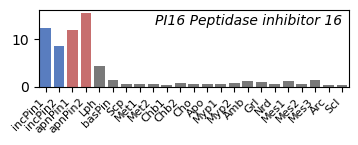

In [12]:
barplot_singlecell('c102644-g1 PI16 (peptidase inhibitor 16) - emapper OG', 'PI16 Peptidase inhibitor 16')

plt.savefig('../paper/figures/fig4/barplot_PI16_expression.svg', bbox_inches='tight')

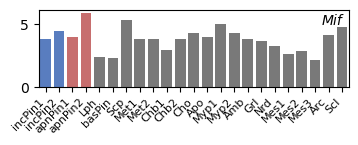

In [13]:
barplot_singlecell('c91796-g1 (Inherit from artNOG: Macrophage migration inhibitory factor (MIF)) - emapper OG', 'Mif')

plt.savefig('../paper/figures/fig4/barplot_MIF_expression.svg', bbox_inches='tight')

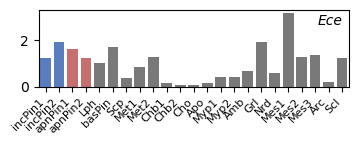

In [14]:
barplot_singlecell('c104426-g1 (endothelin converting enzyme) - emapper OG', 'Ece')

plt.savefig('../paper/figures/suppl_figs/suppl-fig-TPP_peptide_processing/barplot_ECE_expression.svg', bbox_inches='tight')

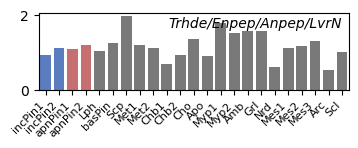

In [15]:
barplot_singlecell('c102777-g1 1-to-4 TRHDE,ENPEP,ANPEP,LVRN thyrotropin releasing hormone degrading enzyme', 'Trhde/Enpep/Anpep/LvrN')

plt.savefig('../paper/figures/suppl_figs/suppl-fig-TPP_peptide_processing/barplot_TRHDE_expression.svg', bbox_inches='tight')

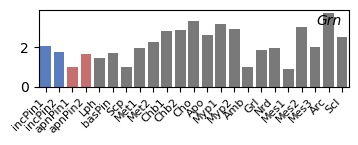

In [16]:
barplot_singlecell('c100456-g4', 'Grn')

plt.savefig('../paper/figures/fig4/barplot_granulin_expression.svg', bbox_inches='tight')

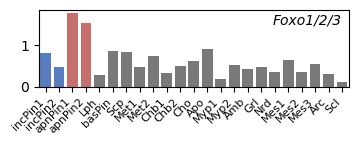

In [17]:
barplot_singlecell('c101327-g2 FOXO3 (forkhead box) - emapper OG', 'Foxo1/2/3')

plt.savefig('../paper/figures/fig3/barplot_foxo_expression.svg', bbox_inches='tight')

# 2. Single cell barplots of multiple proteins of interest

In [18]:
proteinases = ['c100898-g3 (cathepsin) - emapper OG', 
               'c96393-g1 3-to-9 CPA1,CPB2,CPA2,CPA4... carboxypeptidase A1',
               'c103992-g1 TPP1 (Tripeptidyl peptidase I) - emapper OG',
               'c102960-g3 2-to-1 NPEPPS aminopeptidase puromycin sensitive',
               'c99308-g1 2-to-1 CNDP1 carnosine dipeptidase 1',
               'c103969-g1 1-to-1 PREP prolyl endopeptidase',
               'c104061-g1 1-to-1 PEPD peptidase D',
               'c103258-g1 1-to-1 NPEPL1 aminopeptidase like 1',
               'c104647-g2 1-to-1 LAP3 leucine aminopeptidase 3'
               ]

ER_chaperone_complex = ['c103368-g1 HSP90B1 (heat shock protein 90kDa beta (Grp94), member 1) - emapper OG',
                         'c110122-g1 P4HB (protein disulfide isomerase family A, member 2) - emapper OG',
                         'c104733-g1 1-to-1 HYOU1 hypoxia up-regulated 1',
                         'c88024-g1 PDIA3 (Protein disulfide isomerase family A, member) - emapper OG',
                         'c110643-g1 1-to-2 PPIB,PPIC peptidylprolyl isomerase B',
                         'c39783-g1 1-to-1 HSPA5 heat shock protein family A (Hsp70) member 5'
                         ]

ROS_degrading = ['c104520-g1 1-to-2 ALDH1L2,ALDH1L1 aldehyde dehydrogenase 1 family member L2', 
                'c101807-g3 2-to-1 CAT catalase',
                 'c88295-g1 ALDH2 (Aldehyde dehydrogenase 1 family, member) - emapper OG',
                 'c90804-g1 PRDX6 (Peroxiredoxin 6) - emapper OG',
                 'c91813-g1 (Dyp-type peroxidase family) - emapper OG',
                 'c95358-g1 SOD2 (Destroys radicals which are normally produced within the cells and which are toxic to biological systems (By similarity)) - emapper OG',
                 'c101807-g2 2-to-1 CAT catalase',
                 'c104128-g1 MLT-7 (Peroxidasin homolog) - emapper OG',
                 'c93044-g1 SOD (Destroys radicals which are normally produced within the cells and which are toxic to biological systems) - emapper OG'
                 ]

Tric_chaperonin = ['c101223-g1 1-to-1 CCT7 chaperonin containing TCP1 subunit 7',
                   'c101169-g1 1-to-2 CCT6A,CCT6B chaperonin containing TCP1 subunit 6A',
                   'c92647-g1 1-to-1 CCT5 chaperonin containing TCP1 subunit 5',
                   'c102224-g1 CCT3 (Chaperonin containing Tcp1, subunit 3 (Gamma)) - emapper OG',
                   'c98583-g1 1-to-1 CCT8 chaperonin containing TCP1 subunit 8'
                   ]

In [19]:
replace = {
    'c103609-g2 1-to-10 MYH1/2/3/4/6/7/8/13/15 myosin heavy chain 1' : 'stMYH',
    'c104726-g3 1-to-4 MYH9/10/11/14 myosin heavy chain 1' : 'sm/smMYH',
    'c98588-g1 MYL6 (myosin, light chain 6, alkali, smooth muscle and non-muscle) - emapper OG' : 'essential MYL',
    'c97890-g1 MYL9 (myosin light chain) - emapper OG' : 'regulatory MYL',
    'c101746-g1 1-to-1 DAPK1 death associated protein kinase 1' : 'MYLK / DAPK',
    'c104457-g1 1-to-2 PPP1R16A,PPP1R16B protein phosphatase 1 regulatory subunit 16A' : 'MLCP (MYPT) 1',
    'c108134-g1 1-to-2 PPP1R16A,PPP1R16B protein phosphatase 1 regulatory subunit 16A' : 'MLCP (MYPT) 2',
    'c102758-g2 2-to-1 PPP1CC protein phosphatase 1 catalytic subunit gamma' : 'MLCP (PP1C)',
    'c99473-g2 2-to-2 PPP1CA,PPP1CC protein phosphatase 1 catalytic subunit alpha' : 'MLCP (PP1A)',
    'c87912-g1 1-to-4 PPP1R14A,PPP1R14B,LIMK2,PPP1R14C protein phosphatase 1 regulatory inhibitor subunit 14A' : 'MLCP (CPI-17)',
    'c105153-g1 TPM1 (Tropomyosin) - emapper OG' : 'TPM',
    'c79207-g1 CNN3 (Calponin) - emapper OG' : 'TAGLN 1',
    'c79401-g1 CNN3 (Calponin) - emapper OG' : 'TAGLN 2',
    'c96737-g1 CHD64 (transgelin) - emapper OG' : 'TAGLN 3',
    'c101907-g1 LMOD1 (leiomodin 1 (smooth muscle)) - emapper OG' : 'LMOD / TMOD',
    'c100793-g2 (muscle lim protein) - emapper OG' : 'CSRP',
    'c104145-g1 1-to-3 PDLIM7,LDB3,PDLIM5 PDZ and LIM domain 7' : 'PDLIM5/7 / LDB3',
    'c102317-g7 1-to-3 PXN,TGFB1I1,LPXN paxillin' : 'PXN',
    'c103354-g1 1-to-1 VCL vinculin' : 'VCL',
    'c104780-g1 TLN1 (K06271 talin) - emapper OG' : 'TLN 1',
    'c103122-g3 4-to-2 TLN1,TLN2 talin 1' : 'TLN 2',
    'c104152-g2 TNS3 (Tensin 3) - emapper OG' : 'TNS',
    'c93710-g1 1-to-4 FHL5,FHL3,FHL1,FHL2 four and a half LIM domains 5' : 'FHL',
    'c103222-g2 1-to-2 PTK2,PTK2B protein tyrosine kinase 2' : 'PTK',
    'c104087-g2 1-to-1 ILK integrin linked kinase' : 'ILK',
    'c104776-g1 5-to-9 ITGA3,ITGA9,ITGA1,ITGA2... integrin subunit alpha 3' : 'ITGA 1',
    'c103121-g1 ITGA9 (Integrin, alpha) - emapper OG' : 'ITGA 2',
    'c104747-g2 (integrin, beta) - emapper OG' : 'ITGB 1',
    'c104053-g1 (integrin, beta) - emapper OG' : 'ITGB 2', 
    'c104344-g1 3-to-1 ITGB1 integrin subunit beta 1' : 'ITGB 3'
}

In [20]:
acto_myosin_modules = pd.DataFrame.from_dict(replace, orient='index')

In [21]:
acto_myosin_modules.reset_index(inplace=True)
acto_myosin_modules.rename(columns={0:'gene_short', 'index':'gene'}, inplace=True)

/tmp/ipykernel_94/1842916584.py:9: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, ax = plt.subplots(figsize=(4, 1))


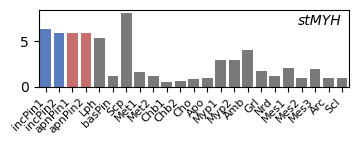

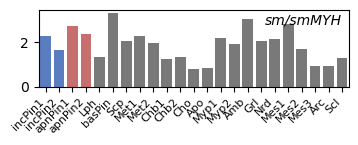

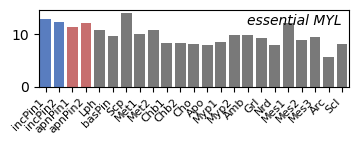

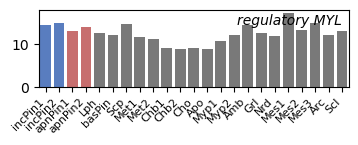

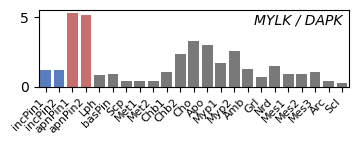

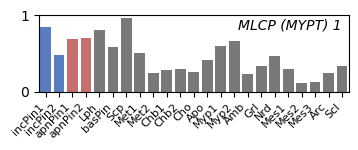

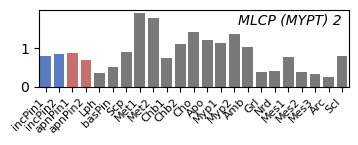

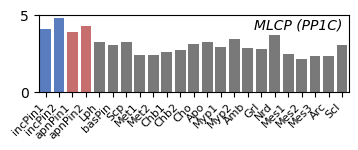

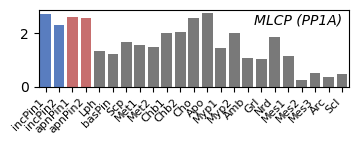

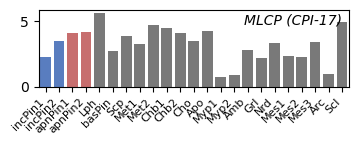

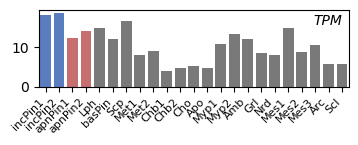

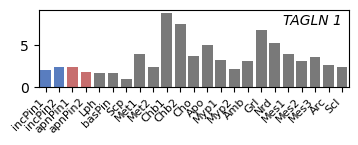

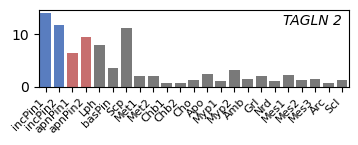

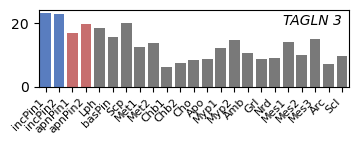

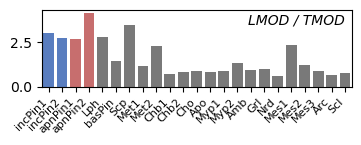

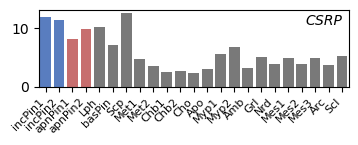

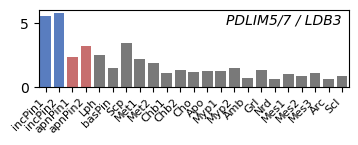

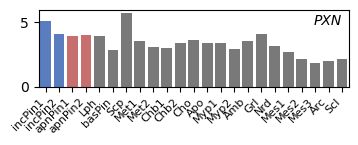

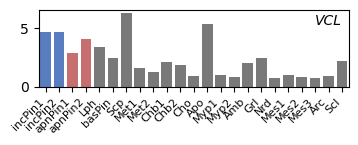

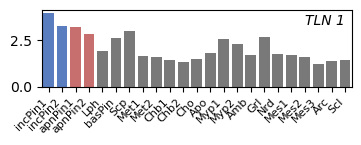

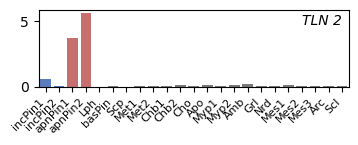

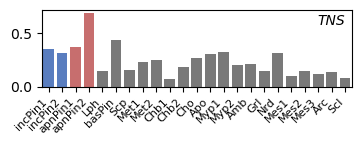

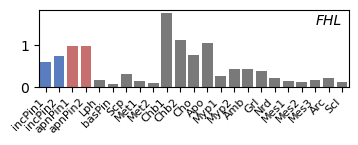

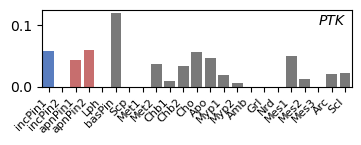

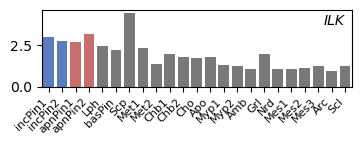

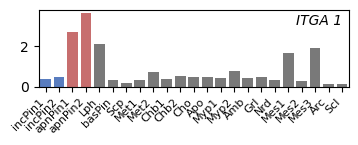

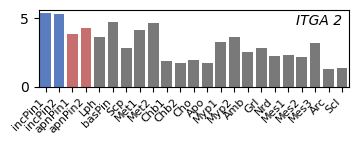

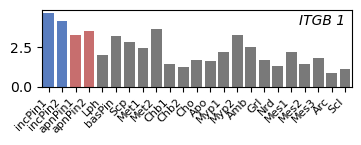

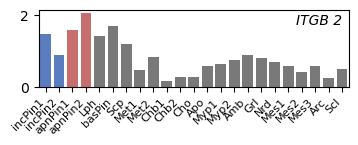

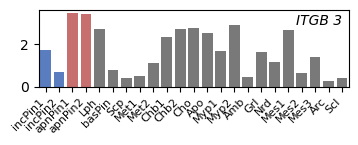

In [22]:
for index, row in acto_myosin_modules.iterrows():
    barplot_singlecell(row['gene'], row['gene_short'])

Now I chose specific genes to plot for the manuscript:

In [23]:
def barplot_singlecell_subplots(gene, plotting_name, ax=None, **kwargs):
    ax = ax
    gene = gene[:110]
    expression = grouped_obs_mean(adata[:,gene], group_key='cell_type').T
    expression['cell_type'] = expression.index
    
    palette = sns.color_palette("muted")
    colors = [palette[0], palette[0], palette[3], palette[3], palette[7], palette[7], palette[7], palette[7], palette[7], palette[7], palette[7], palette[7], palette[7], palette[7], palette[7], palette[7], palette[7], palette[7], palette[7], palette[7], palette[7], palette[7], palette[7]]
    
    sns.barplot(data = expression, x='cell_type', y=gene, order=celltypes_by_family, palette=colors, ax=ax)
    ax.set_xticklabels(celltypes_by_family_abb, rotation=45, ha='right', fontsize=7)
    ax.set_ylabel('')
    ax.set_xlabel('')
    ax.set_ylim(0, 1.2 * max(expression[gene]))
    ax.text(22, 1.15 * max(expression[gene]), plotting_name, va="top", ha="right", fontsize = 10, style='italic')

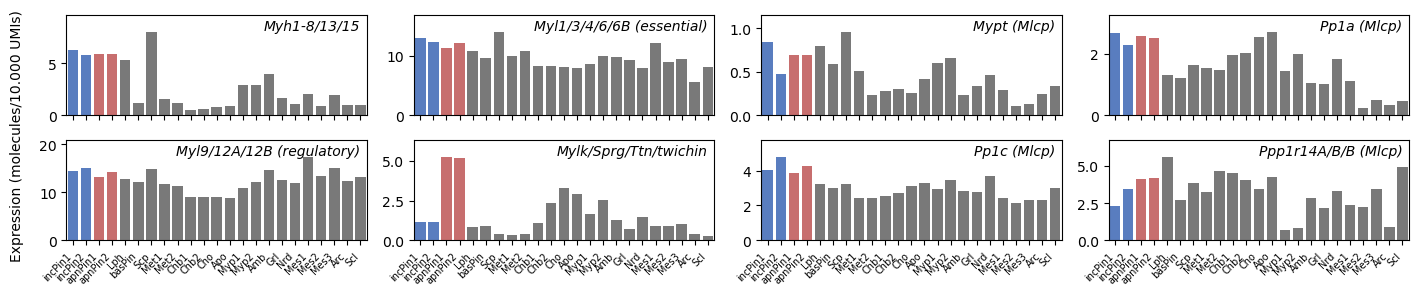

In [24]:
fig, axs = plt.subplots(2,4, figsize=(14,3), sharex=True, facecolor='none')

barplot_singlecell_subplots('c103609-g2 1-to-10 MYH1/2/3/4/6/7/8/13/15 myosin heavy chain 1', 'Myh1-8/13/15', ax=axs[0,0])
barplot_singlecell_subplots('c98588-g1 MYL6 (myosin, light chain 6, alkali, smooth muscle and non-muscle) - emapper OG', 'Myl1/3/4/6/6B (essential)', ax=axs[0,1])
barplot_singlecell_subplots('c97890-g1 MYL9 (myosin light chain) - emapper OG', 'Myl9/12A/12B (regulatory)', ax=axs[1,0])
barplot_singlecell_subplots('c101746-g1 1-to-1 DAPK1 death associated protein kinase 1', 'Mylk/Sprg/Ttn/twichin', ax=axs[1,1])
barplot_singlecell_subplots('c104457-g1 1-to-2 PPP1R16A,PPP1R16B protein phosphatase 1 regulatory subunit 16A', 'Mypt (Mlcp)', ax=axs[0,2])
barplot_singlecell_subplots('c102758-g2 2-to-1 PPP1CC protein phosphatase 1 catalytic subunit gamma', 'Pp1c (Mlcp)', ax=axs[1,2])
barplot_singlecell_subplots('c99473-g2 2-to-2 PPP1CA,PPP1CC protein phosphatase 1 catalytic subunit alpha', 'Pp1a (Mlcp)', ax=axs[0,3])
barplot_singlecell_subplots('c87912-g1 1-to-4 PPP1R14A,PPP1R14B,LIMK2,PPP1R14C protein phosphatase 1 regulatory inhibitor subunit 14A', 'Ppp1r14A/B/B (Mlcp)', ax=axs[1,3])

fig.text(-.01, 0.55, 'Expression (molecules/10.000 UMIs)', va='center', rotation='vertical')

plt.tight_layout()
plt.savefig('../paper/figures/fig2/core_expression.svg', bbox_inches='tight', facecolor='none')
for ax in axs.flatten():
    ax.patch.set_alpha(1.0)

In [17]:
replace = {
    'c103457-g1 1-to-3 NOS3,NOS2,NOS1 nitric oxide synthase 3' : 'NOS', 
    'c104670-g4 1-to-1 NOS1AP nitric oxide synthase 1 adaptor protein' : 'NOS1AP',
    'c102529-g1 GUCY1B2 (guanylate cyclase 1, soluble) - emapper OG' : 'GUCY1B2', 
    'c102529-g2 1-to-1 GUCY1B3 guanylate cyclase 1 soluble subunit beta' : 'GUCY1B3',
    'c99896-g1 2-to-2 PRKG2,PRKG1 protein kinase, cGMP-dependent, type II' : 'PRKG',
    'c104529-g1 1-to-1 PDE2A phosphodiesterase 2A' : 'PDE2A',
    'c102618-g1 1-to-2 PDE8B,PDE8A phosphodiesterase 8B' : 'PDE8A/B',
    'c103195-g1 1-to-2 PDE1C,PDE1A phosphodiesterase 1C' : 'PDE1A/C'
}

In [18]:
nitric_oxide_signaling = pd.DataFrame.from_dict(replace, orient='index')

In [19]:
nitric_oxide_signaling.reset_index(inplace=True)
nitric_oxide_signaling.rename(columns={0:'gene_short', 'index':'gene'}, inplace=True)

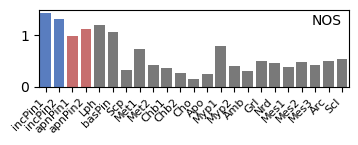

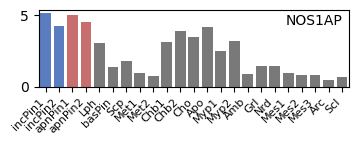

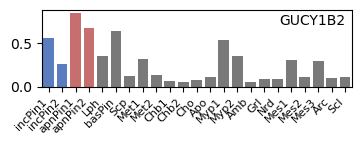

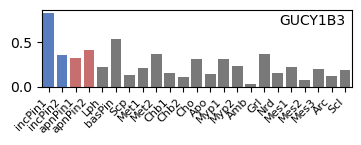

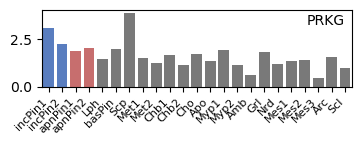

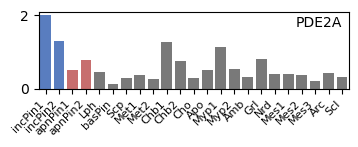

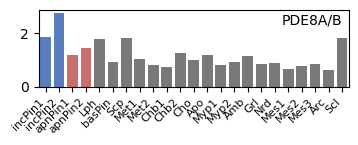

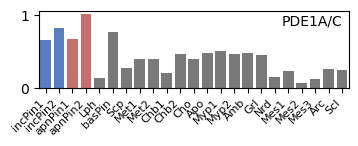

In [20]:
for index, row in nitric_oxide_signaling.iterrows():
    barplot_singlecell(row['gene'], row['gene_short'])

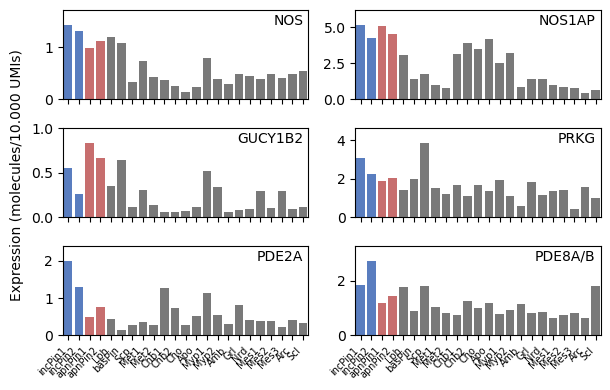

In [21]:
fig, axs = plt.subplots(3,2, figsize=(6,4), sharex=True)

barplot_singlecell_subplots('c103457-g1 1-to-3 NOS3,NOS2,NOS1 nitric oxide synthase 3', 'NOS', ax=axs[0,0])
barplot_singlecell_subplots('c104670-g4 1-to-1 NOS1AP nitric oxide synthase 1 adaptor protein', 'NOS1AP', ax=axs[0,1])
barplot_singlecell_subplots('c102529-g1 GUCY1B2 (guanylate cyclase 1, soluble) - emapper OG', 'GUCY1B2', ax=axs[1,0])
barplot_singlecell_subplots('c99896-g1 2-to-2 PRKG2,PRKG1 protein kinase, cGMP-dependent, type II', 'PRKG', ax=axs[1,1])
barplot_singlecell_subplots('c104529-g1 1-to-1 PDE2A phosphodiesterase 2A', 'PDE2A', ax=axs[2,0])
barplot_singlecell_subplots('c102618-g1 1-to-2 PDE8B,PDE8A phosphodiesterase 8B', 'PDE8A/B', ax=axs[2,1])

fig.text(-.01, 0.55, 'Expression (molecules/10.000 UMIs)', va='center', rotation='vertical')

plt.tight_layout()
plt.show()

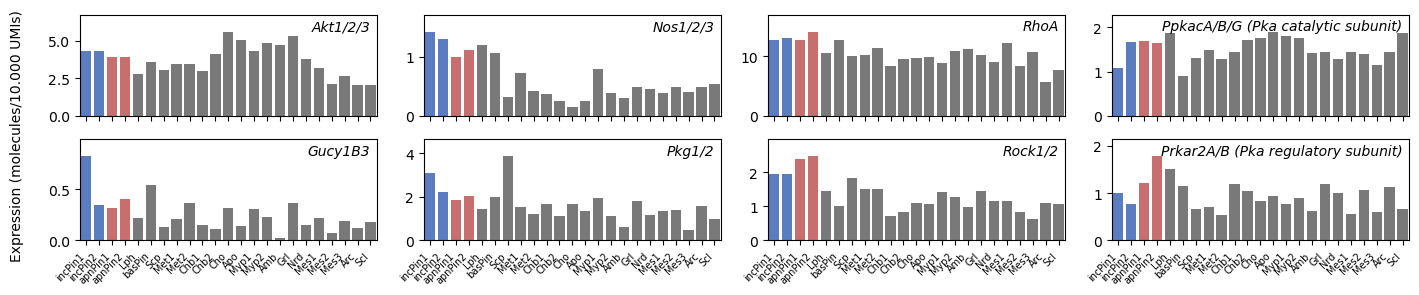

In [25]:
fig, axs = plt.subplots(2,4, figsize=(14,3), sharex=True, facecolor='none')
plt.subplots_adjust(hspace = 0)

barplot_singlecell_subplots('c101822-g1 AKT3 (v-akt murine thymoma viral oncogene homolog) - emapper OG', 'Akt1/2/3', ax=axs[0,0])
barplot_singlecell_subplots('c103457-g1 1-to-3 NOS3,NOS2,NOS1 nitric oxide synthase 3', 'Nos1/2/3', ax=axs[0,1])
barplot_singlecell_subplots('c102529-g2 1-to-1 GUCY1B3 guanylate cyclase 1 soluble subunit beta', 'Gucy1B3', ax=axs[1,0])
barplot_singlecell_subplots('c99896-g1 2-to-2 PRKG2,PRKG1 protein kinase, cGMP-dependent, type II', 'Pkg1/2', ax=axs[1,1])

barplot_singlecell_subplots('c91721-g1 RHOA (ras homolog family member) - emapper OG' , 'RhoA', ax=axs[0,2])
barplot_singlecell_subplots('c104144-g1 1-to-2 ROCK2,ROCK1 Rho associated coiled-coil containing protein kinase 2' , 'Rock1/2', ax=axs[1,2])

barplot_singlecell_subplots('c104137-g1 1-to-3 PRKACA,PRKACB,PRKACG protein kinase cAMP-activated catalytic subunit alpha', 'PpkacA/B/G (Pka catalytic subunit)', ax=axs[0,3])
barplot_singlecell_subplots('c97421-g1 1-to-2 PRKAR2A,PRKAR2B protein kinase cAMP-dependent type II regulatory subunit alpha', 'Prkar2A/B (Pka regulatory subunit)', ax=axs[1,3])

fig.text(-.01, 0.55, 'Expression (molecules/10.000 UMIs)', va='center', rotation='vertical')

plt.tight_layout()
plt.savefig('../paper/figures/fig2/regulation_expression.svg', bbox_inches='tight', facecolor='none')
for ax in axs.flatten():
    ax.patch.set_alpha(1.0)

In [27]:
def barplot_singlecell_subplots_color(gene, plotting_name, color, ax=None, **kwargs):
    ax = ax
    gene = gene[:110]
    expression = grouped_obs_mean(adata[:,gene], group_key='cell_type').T
    expression['cell_type'] = expression.index
    
    palette = sns.color_palette("muted")
    colors = [palette[0], palette[0], palette[3], palette[3], palette[7], palette[7], palette[7], palette[7], palette[7], palette[7], palette[7], palette[7], palette[7], palette[7], palette[7], palette[7], palette[7], palette[7], palette[7], palette[7], palette[7], palette[7], palette[7]]
    
    sns.barplot(data = expression, x='cell_type', y=gene, order=celltypes_by_family, palette=colors, ax=ax)
    ax.set_xticklabels(celltypes_by_family_abb, rotation=45, ha='right', fontsize=6)
    ax.set_ylabel('')
    ax.set_xlabel('')
    ax.text(22, max(expression[gene]), plotting_name, va="top", ha="right", fontsize = 10, color=color, style='italic')

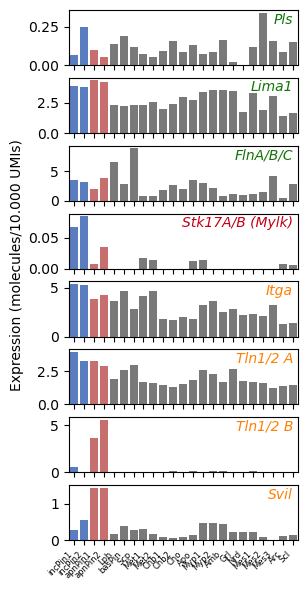

In [29]:
fig, axs = plt.subplots(8,1, figsize=(3,6), sharex=True)

barplot_singlecell_subplots_color('c93563-g2 PLS1 (lymphocyte cytosolic protein 1 (L-plastin)) - emapper OG', 'Pls', '#127409', ax=axs[0])
barplot_singlecell_subplots_color('c99862-g1 LIMA1 (LIM domain and actin binding 1) - emapper OG', 'Lima1', '#127409', ax=axs[1])
barplot_singlecell_subplots_color('c103902-g5 FLNB (Filamin A, alpha) - emapper OG', 'FlnA/B/C', '#127409', ax=axs[2])

barplot_singlecell_subplots_color('c96307-g1 1-to-2 STK17B,STK17A serine/threonine kinase 17b', 'Stk17A/B (Mylk)', '#C30017', ax=axs[3])

barplot_singlecell_subplots_color('c103121-g1 ITGA9 (Integrin, alpha) - emapper OG', 'Itga', '#FF8000', ax=axs[4])
barplot_singlecell_subplots_color('c104780-g1 TLN1 (K06271 talin) - emapper OG', 'Tln1/2 A', '#FF8000', ax=axs[5])
barplot_singlecell_subplots_color('c103122-g3 4-to-2 TLN1,TLN2 talin 1', 'Tln1/2 B', '#FF8000', ax=axs[6])
barplot_singlecell_subplots_color('c103424-g3 SVIL (supervillin) - blastp', 'Svil', '#FF8000', ax=axs[7])

fig.text(-.01, 0.55, 'Expression (molecules/10.000 UMIs)', va='center', rotation='vertical')

plt.tight_layout(h_pad=0.3)
plt.savefig('../paper/figures/fig3/acto_myosin_expression.svg', bbox_inches='tight', facecolor='none')
for ax in axs.flatten():
    ax.patch.set_alpha(1.0)